## Base Code
This code is provided by [Mat Disney, Phil Wilkes etc] 
Running on data from Calders et al.

In [1]:
# Code is from TLS_Inventory
import numpy as np
import pandas as pd
import glob
import sys
import os
import open3d as o3d

from shapely.ops import cascaded_union, polygonize
from shapely.geometry import Polygon, LineString
import shapely.geometry as geometry

from scipy import optimize
from scipy.spatial import ConvexHull, Delaunay
import scipy.io as sio

from matplotlib import pyplot as plt, cm, colors

import math
from math import pi

from sklearn.neighbors import NearestNeighbors
from descartes import PolygonPatch


Bad key text.latex.preview in file /Users/snix/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/snix/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /Users/snix/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the defau

In [2]:
# Functions from TLS_Inventory
# Some of the docstrings for functions added by Sabine to help make code easier to understand and modify later on.

# neareast neighbour needed for outlier removal
def nn(x,rad):
    """
    Function from TLS_Inventory.
    
    x: a numpy array, rad: radius to search for neighbors within
    
    My understanding - can either specify number of neighbors to return (in sklearn NearestNeighbors),
    or return all the neighbors and then filter to return only those within a specified distance radius
    """
    nbrs = NearestNeighbors(algorithm='auto', metric='euclidean').fit(x) 
    distances, indices = nbrs.radius_neighbors(radius=rad) #find all neighbours within this search radius
    
    #output explained: https://stackoverflow.com/questions/53886289/confused-with-the-output-of-sklearn-neighbors-nearestneighbors 
    return distances, indices


def load_pts(cloud,downsample=False,outliers=False): 
    """
    Function from TLS_Inventory that reads the point cloud data for single tree at a time and
    returns pandas dataframe with the points split into x, y, z coordinates. 
    
    cloud: point cloud from a single tree - note, point cloud data should be pre-processed and 
           split into individual trees prior to using this function.
    downsample (Optional): Default is False, meaning all the points are retained. If 
                           True, the point clouds are sampled to keep only fraction of points.
    outliers (Optional): Default is False, meaning outliers are retained. If True, 
    """
    # read the point cloud data for single tree and save as pandas df with columns for x, y, z coords
    dftemp=o3d.io.read_point_cloud(cloud)
    df=pd.DataFrame(data=np.asarray(dftemp.points),columns=['x', 'y', 'z']) #access the points
    
    # Optional downsampling
    if downsample:
        df=df.sample(frac=0.1) # keep 10pct of points
    
    # Optional outlier removal 
    if outliers: #remove outliers
        xy=df.iloc[:,0:2].values # takes ALL rows, first and second column - x and y - and .values converts to numpy array
        dist, indi = nn(xy,0.5) # get nearest neighbors within search radius of 0.5
        cnt=[len(i) for i in indi] # count the kNN within the search radius
        cnt = pd.DataFrame({'count':cnt})
        
        # set threshold for the number of neighbors we want to keep 
        threshold=df.shape[0]*0.0001 #1 neighbor for every 10 000 pts
        
        removed=sum(np.array(cnt)<threshold)
        df=df[np.array(cnt)>=threshold]
        print("Removed %i outliers using kNN threshold %.2f" % (removed[0], threshold-1))
    
    return df #return pandas dataframe 

def plot_polygon(x,y,polygon,treename):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    margin = .3 #plotbounds margin
    x_min, y_min, x_max, y_max = polygon.bounds
    ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([y_min-margin, y_max+margin])
    plt.axis('equal')
    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    plt.plot(x, y, 'ro', label='data', mew=1,alpha=0.3,zorder=1)
    patch = PolygonPatch(polygon, fc='#999999',ec='#000000', fill=True,zorder=2,label='Concave hull',alpha=0.5,lw=2)
    ax.add_patch(patch)
    plt.legend(loc='best',labelspacing=0.1 )
    plt.grid()
    plt.title("Vertical crown projection of %s" %treename)
#     plt.show()
    if not os.path.exists('plot/VCP/'):
        os.makedirs('plot/VCP')
    plt.savefig('plot/VCP/VCP_'+str(treename)+'.png')
    plt.close()
    
def alpha_shape(x, y, alpha,treename,plotsavefig=False):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    points=list(zip(x,y))
    points=[geometry.Point(point) for point in points]
    total_area = 0
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])
    coords = np.array([point.coords[0] for point in points])
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for ia, ib, ic in tri.simplices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha: #the larger alpha, the fewer triangles will be included
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    poly=cascaded_union(triangles)
    if plotsavefig:
        #print('df', df.shape)
        #print(df.head)
        #print(poly)
        plot_polygon(df['x'],df['y'],poly,treename)
    return poly.area, poly.length, poly, edge_points

def calc_hgt(z): #z is pandasdf column of z
    hgt=z.max() - z.min()
    return hgt

def calc_R(x,y, xc, yc):
    """ calculate the distance of each 2D points from the center (xc, yc) """
    return np.sqrt((x-xc)**2 + (y-yc)**2)
        
def f(c, x, y):
    """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
    Ri = calc_R(x, y, *c)
    return Ri - Ri.mean()
    
def plot_dbh(x,y, xc, yc, R,polygon,df,treename,QSM=True):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    x_min, y_min, x_max, y_max = polygon.bounds
    plt.axis('equal')
    theta_fit = np.linspace(-pi, pi, 180)
    x_fit = xc + R*np.cos(theta_fit)
    y_fit = yc + R*np.sin(theta_fit)
    plt.plot(x_fit, y_fit, 'b-' , label="fitted circle", lw=2,zorder=5)
    plt.plot([xc], [yc], 'bD', mec='y', mew=1)
    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    if QSM:
        iter_list = glob.glob("%s%s-*" % (qsm_path,treename))
        print('list of qsm: ', iter_list)
        lab_legend=0
        for qsmfile in iter_list:
            data = sio.loadmat(qsmfile)
            i = 0
            while sum(data['Len'][0:i+1]) < 1.3:
                i = i+1;
            offset_of_dbhHeight=1.3-sum(data['Len'][0:i])
            #need to correct the xy location for plotting since it's a cylinder spanning some length
            xqsm = data['Sta'][i][0]+offset_of_dbhHeight*data['Axe'][i][0]
            yqsm = data['Sta'][i][1]+offset_of_dbhHeight*data['Axe'][i][1]
            Rqsm = data['Rad'][i][0]
            df_qsm = df[(df['z'] > data['Sta'][i][2])  & (df['z'] < data['Sta'][i][2]+data['Len'][i][0])]
            if (lab_legend == 0): #only need legend once
#                 plt.plot(df_qsm['x'], df_qsm['y'], 'go', label='Points construction QSM', mew=1,alpha=0.2,zorder=-1)
                xqsm_fit = xqsm + Rqsm*np.cos(theta_fit)
                yqsm_fit = yqsm + Rqsm*np.sin(theta_fit)
                plt.plot(xqsm_fit, yqsm_fit, 'g-' , label="QSM cylinder", lw=2,zorder=3)  
                lab_legend=1
            else:
#                plt.plot(df_qsm['x'], df_qsm['y'], 'go', mew=1,alpha=0.3) #don't need to plot these points 10 times, might be "problem" if cylinder close to 1.3m length
                xqsm_fit = xqsm + Rqsm*np.cos(theta_fit)
                yqsm_fit = yqsm + Rqsm*np.sin(theta_fit)
                plt.plot(xqsm_fit, yqsm_fit, 'g-', lw=2,zorder=2)  
    # plot data
    plt.plot([xqsm], [yqsm], 'gD', mec='y', mew=1)
    plt.plot(x, y, 'ro', label='Points circle fit', mew=1,alpha=0.3,zorder=4)
    patch = PolygonPatch(polygon, fc='#999999',ec='#000000', fill=True,label='Concave hull',zorder=2,alpha=0.7)
    ax.add_patch(patch)
    plt.legend(loc='best',labelspacing=0.1 )
    plt.grid()
    plt.title("DBH cross section of %s" %treename)
    if not os.path.exists('plot/DBH/'):
        os.makedirs('plot/DBH')
    plt.savefig('plot/DBH/DBH_'+str(treename)+'.png')
    plt.show()
    plt.close()


def calc_dbh(treename,df): #treename string, pandasdf with x y z columns
    if df['z'].max() - df['z'].min() > 1.3: #check if tree is at least 1.3m height
        #get slice 1.27 - 1.33 m - limits according to Tansey et al 2009; Calders et al. 2015
        df_dbh = df[(df['z'] > df['z'].min() + 1.27) & (df['z'] < df['z'].min() + 1.33)]
        #filter outliers of DBH slice:
        #take xy data only
        xy=df_dbh.iloc[:,0:2].values #takes ALL rows, first and second column - x and y - and .values converts to numpy array
        dist, indi = nn(xy,0.05)
        cnt=[len(i) for i in indi] #count the kNN within the search radius
        cnt = pd.DataFrame({'count':cnt})
        threshold=2
        removed=sum(np.array(cnt)<threshold)
        df_dbh=df_dbh[np.array(cnt)>=threshold]
        print("Removed %i outliers from DBH slice using kNN threshold %.2f" % (removed[0], threshold-1))
        ###
        x = df_dbh['x']
        y = df_dbh['y']
        #calc DBH ; from https://scipy-cookbook.readthedocs.io/items/Least_Squares_Circle.html
        #Optimize.leastsq is the most efficient method ; algebraic does not work well when not full circle is covered
            # coordinates of the barycenter
        x_m = x.mean() #as first estimte of center
        y_m = y.mean()
        center_estimate = x_m, y_m
        center, ier = optimize.leastsq(f, center_estimate, args=(x,y)) #f is the function you want to optimise/minimise
        xc, yc = center
        Ri       = calc_R(x, y, *center)
        R        = Ri.mean() #this is the radius
        residu   = np.sum((Ri - R)**2)/len(Ri) #avg residual between pts and fitted circle
        #outer hull:
        ##slightly larger alpha here, want to resolve some detail in dbh slice
        Tarea, Lshape, concave_hull, edge_points = alpha_shape(x,y,5,treename,False) 
        plot_dbh(x,y, xc, yc, R,concave_hull,df,treename,True)
    else:
        xc = yc = R = residu = 'NA'
    return xc, yc, R, residu, Tarea, Lshape, concave_hull

def averageQSM(treename,path_to_qsm): #this will calculate the average of multiple QSM iterations of treename
    iter_list = glob.glob("%s%s-*" % (path_to_qsm,treename))
    if (len(iter_list) != 10):
        sys.exit("There are no 10 QSMs for tree %s" %treename)
    vol = []
    dbh = []
    x_qsm = []
    y_qsm = []
    vol0_25 = []
    vol25_50 = []
    vol50_75 = []
    vol75_100 = []
    vol100_200 = []
    vol200_500 = []
    vol500_1000 = []
    vol1000 = []
    #Loop over iterations of QSM
    for file in iter_list:
#         print("opening %s" %file)
        data = sio.loadmat(file)
        vol.append(data['TreeData'][0][0]/1000) #convert to m3
        dbh.append(data['TreeData'][9][0]/100) #convert to m
        i=0
        while sum(data['Len'][0:i+1]) < 1.3:
            i = i+1;
        if (sum(data['Len'][0:i])==0):
            offset_of_dbhHeight=1.3-sum(data['Len'][0:i])
        else:
            offset_of_dbhHeight=1.3-sum(data['Len'][0:i][0])
        #need to correct the xy location for plotting since it's a cylinder spanning some length
        x_qsm.append(data['Sta'][i][0]+offset_of_dbhHeight*data['Axe'][i][0])
        y_qsm.append(data['Sta'][i][1]+offset_of_dbhHeight*data['Axe'][i][1])
        #calculate vols per diam class
        #divide in classes
        tmp_vol0_25 = []
        tmp_vol25_50 = []
        tmp_vol50_75 = []
        tmp_vol75_100 = []
        tmp_vol100_200 = []
        tmp_vol200_500 = []
        tmp_vol500_1000 = []
        tmp_vol1000 = []
        for i in range(0,len(data['Rad'])):
            if (data['Rad'][i]<=0.0125):
                tmp_vol0_25.append(pi*data['Len'][i][0]*data['Rad'][i][0]**2) #this is m3
            elif (data['Rad'][i]<=0.025):
                tmp_vol25_50.append(pi*data['Len'][i][0]*data['Rad'][i][0]**2) #this is m3
            elif (data['Rad'][i]<=0.0375):
                tmp_vol50_75.append(pi*data['Len'][i][0]*data['Rad'][i][0]**2) #this is m3
            elif (data['Rad'][i]<=0.05):
                tmp_vol75_100.append(pi*data['Len'][i][0]*data['Rad'][i][0]**2) #this is m3
            elif (data['Rad'][i]<=0.1):
                tmp_vol100_200.append(pi*data['Len'][i][0]*data['Rad'][i][0]**2) #this is m3
            elif (data['Rad'][i]<=0.25):
                tmp_vol200_500.append(pi*data['Len'][i][0]*data['Rad'][i][0]**2) #this is m3
            elif (data['Rad'][i]<=0.5):
                tmp_vol500_1000.append(pi*data['Len'][i][0]*data['Rad'][i][0]**2) #this is m3
            else:
                tmp_vol1000.append(pi*data['Len'][i][0]*data['Rad'][i][0]**2) #this is m3
        # sum up per class
        vol0_25.append(sum(tmp_vol0_25))
        vol25_50.append(sum(tmp_vol25_50))
        vol50_75.append(sum(tmp_vol50_75))
        vol75_100.append(sum(tmp_vol75_100))
        vol100_200.append(sum(tmp_vol100_200))
        vol200_500.append(sum(tmp_vol200_500))
        vol500_1000.append(sum(tmp_vol500_1000))
        vol1000.append(sum(tmp_vol1000))
    #Calculate avg and sd of QSM
    vol_avg = np.mean(vol,axis=0)
    vol_sd = np.std(vol, ddof=1,axis=0) #the same as excell STDEV
    dbh_avg = np.mean(dbh,axis=0)
    dbh_sd = np.std(dbh, ddof=1,axis=0) #the same as excell STDEV
    xqsm= np.mean(x_qsm,axis=0)
    yqsm= np.mean(y_qsm,axis=0)
    vol0_25_avg = np.mean(vol0_25,axis=0)
    vol0_25_sd = np.std(vol0_25, ddof=1,axis=0) #the same as excell STDEV
    vol25_50_avg = np.mean(vol25_50,axis=0)
    vol25_50_sd = np.std(vol25_50, ddof=1,axis=0) #the same as excell STDEV
    vol50_75_avg = np.mean(vol50_75,axis=0)
    vol50_75_sd = np.std(vol50_75, ddof=1,axis=0) #the same as excell STDEV
    vol75_100_avg = np.mean(vol75_100,axis=0)
    vol75_100_sd = np.std(vol75_100, ddof=1,axis=0) #the same as excell STDEV
    vol100_200_avg = np.mean(vol100_200,axis=0)
    vol100_200_sd = np.std(vol100_200, ddof=1,axis=0) #the same as excell STDEV
    vol200_500_avg = np.mean(vol200_500,axis=0)
    vol200_500_sd = np.std(vol200_500, ddof=1,axis=0) #the same as excell STDEV
    vol500_1000_avg = np.mean(vol500_1000,axis=0)
    vol500_1000_sd = np.std(vol500_1000, ddof=1,axis=0) #the same as excell STDEV
    vol1000_avg = np.mean(vol1000,axis=0)
    vol1000_sd = np.std(vol1000, ddof=1,axis=0) #the same as excell STDEV

    return xqsm, yqsm,vol_avg, vol_sd, dbh_avg, dbh_sd,vol0_25_avg,vol0_25_sd,\
    vol25_50_avg,vol25_50_sd,vol50_75_avg,vol50_75_sd,vol75_100_avg,vol75_100_sd,\
    vol100_200_avg,vol100_200_sd,vol200_500_avg,vol200_500_sd,vol500_1000_avg,vol500_1000_sd,\
    vol1000_avg,vol1000_sd

## Main Code - from TLS Inventory

In [3]:
pts_path = "/Users/snix/Documents/2021-2023/UCL/Dissertation/subset_data_ply"
qsm_path = "/Users/snix/Documents/2021-2023/UCL/Dissertation/DATA_QSM_opt/"
tree_csv_path = "/Users/snix/Documents/2021-2023/UCL/Dissertation/Calders Et Al/analysis_and_figures/trees_summary.csv"


In [4]:
#header output file
"""
f_out = open('tls_summary3.csv','w')
f_out.write('Tree_ID,stemlocx_[m],stemlocy_[m],stemloc_source,DBH_pts_[m],DBH_QSM_avg_[m],\
DBH_QSM_sd[m],Hgt_pts_[m],VerticalCrownProjectedArea_pts_[m2],Vol_QSM_avg_[m3],Vol_QSM_sd_[m3],\
Vol_QSM_D0_25mm_avg_[m3],Vol_QSM_D0_25mm_sd_[m3],Vol_QSM_D25_50mm_avg_[m3],Vol_QSM_D25_50mm_sd_[m3],\
Vol_QSM_D50_75mm_avg_[m3],Vol_QSM_D50_75mm_sd_[m3],Vol_QSM_D75_100mm_avg_[m3],Vol_QSM_D75_100mm_sd_[m3],\
Vol_QSM_D100_200mm_avg_[m3],Vol_QSM_D100_200mm_sd_[m3],Vol_QSM_D200_500mm_avg_[m3],Vol_QSM_D200_500mm_sd_[m3],\
Vol_QSM_D500_1000mm_avg_[m3],Vol_QSM_D500_1000mm_sd_[m3],Vol_QSM_D1000mm_avg_[m3],Vol_QSM_D1000mm_sd_[m3]\n')
"""

592

In [5]:
trees = glob.glob("%s/*ply" % pts_path)

print(trees)

['/Users/snix/Documents/2021-2023/UCL/Dissertation/subset_data_ply/wytham_winter_6.ply', '/Users/snix/Documents/2021-2023/UCL/Dissertation/subset_data_ply/wytham_winter_9.ply', '/Users/snix/Documents/2021-2023/UCL/Dissertation/subset_data_ply/wytham_winter_8b.ply', '/Users/snix/Documents/2021-2023/UCL/Dissertation/subset_data_ply/wytham_winter_8a.ply', '/Users/snix/Documents/2021-2023/UCL/Dissertation/subset_data_ply/wytham_winter_5b.ply', '/Users/snix/Documents/2021-2023/UCL/Dissertation/subset_data_ply/wytham_winter_5a.ply']


In [14]:
# separate single and multistemed trees

singlestemmed = []
multistemmed = []

for tree in trees:
    treeID = tree.split("/")[-1].split(".")[0]
    print(f"Current tree: {treeID}")
    
    # if the treeID ends in a letter, it is not single stem
    if treeID[-1].isalpha():
        # add the tree to multistemmed list
        multistemmed.append(tree)
    else:
        # add the tree to the singlestemmed list
        singlestemmed.append(tree)
        
        
print(singlestemmed)
print(multistemmed)
     

Current tree: wytham_winter_6
Tree ID wytham_winter_6 is single stem
Current tree: wytham_winter_9
Tree ID wytham_winter_9 is single stem
Current tree: wytham_winter_8b
Tree ID wytham_winter_8b is not single stem
Current tree: wytham_winter_8a
Tree ID wytham_winter_8a is not single stem
Current tree: wytham_winter_5b
Tree ID wytham_winter_5b is not single stem
Current tree: wytham_winter_5a
Tree ID wytham_winter_5a is not single stem
['/Users/snix/Documents/2021-2023/UCL/Dissertation/subset_data_ply/wytham_winter_6.ply', '/Users/snix/Documents/2021-2023/UCL/Dissertation/subset_data_ply/wytham_winter_9.ply']
['/Users/snix/Documents/2021-2023/UCL/Dissertation/subset_data_ply/wytham_winter_8b.ply', '/Users/snix/Documents/2021-2023/UCL/Dissertation/subset_data_ply/wytham_winter_8a.ply', '/Users/snix/Documents/2021-2023/UCL/Dissertation/subset_data_ply/wytham_winter_5b.ply', '/Users/snix/Documents/2021-2023/UCL/Dissertation/subset_data_ply/wytham_winter_5a.ply']


### Predict DBH:

In [43]:
treedata = pd.read_csv(tree_csv_path)

#print column names
treedata.columns.values

treedata = treedata[['TLS_ID','stemlocx_[m]', 'stemlocy_[m]', 'DBH_TLS_[m]',
                    'Hgt_pts_[m]', 'VerticalCrownProjectedArea_pts_[m2]', 'Vol_QSM_avg_[m3]',
                    'Vol_QSM_D0_25mm_avg_[m3]', 'Vol_QSM_D25_50mm_avg_[m3]', 'Vol_QSM_D50_75mm_avg_[m3]',
                    'Vol_QSM_D75_100mm_avg_[m3]', 'Vol_QSM_D100_200mm_avg_[m3]', 'Vol_QSM_D200_500mm_avg_[m3]',
                    'Vol_QSM_D500_1000mm_avg_[m3]', 'Vol_QSM_D1000mm_avg_[m3]']]

treedata.head()

,TLS_ID,stemlocx_[m],stemlocy_[m],DBH_TLS_[m],Hgt_pts_[m],VerticalCrownProjectedArea_pts_[m2],Vol_QSM_avg_[m3],Vol_QSM_D0_25mm_avg_[m3],Vol_QSM_D25_50mm_avg_[m3],Vol_QSM_D50_75mm_avg_[m3],Vol_QSM_D75_100mm_avg_[m3],Vol_QSM_D100_200mm_avg_[m3],Vol_QSM_D200_500mm_avg_[m3],Vol_QSM_D500_1000mm_avg_[m3],Vol_QSM_D1000mm_avg_[m3]
0,596,60.374237,128.251817,0.276168,18.054895,25.463229,1.12920,0.035336,0.183202,0.157103,0.075745,0.247285,0.430486,0.0,0.0
1,8429,28.657077,174.806063,0.063220,6.398015,7.790878,0.03185,0.008438,0.009992,0.012589,0.000827,0.000000,0.000000,0.0,0.0
2,8367,25.022303,143.800540,0.103076,10.882460,7.674216,0.09334,0.009136,0.025685,0.014223,0.025702,0.018587,0.000000,0.0,0.0
3,8373,0.380455,165.685679,0.098742,8.950477,22.697827,0.13240,0.032013,0.068690,0.014504,0.016977,0.000256,0.000000,0.0,0.0
4,640b,27.574581,120.181330,0.112511,12.758140,9.086388,0.12100,0.007610,0.032402,0.023351,0.030486,0.027010,0.000000,0.0,0.0


In [57]:
# select only single stem trees from csv 
ss_treedata = treedata[treedata[['TLS_ID']].apply(lambda x: x[-1].isdigit(), axis=1)]

In [63]:
#https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# Labels are the values we want to predict
labels = np.array(ss_treedata['DBH_TLS_[m]'])

# Remove the labels from the features
# axis 1 refers to the columns
features = ss_treedata.drop(['TLS_ID','DBH_TLS_[m]'], axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [64]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)



In [65]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (417, 13)
Training Labels Shape: (417,)
Testing Features Shape: (140, 13)
Testing Labels Shape: (140,)


In [66]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [67]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')



Mean Absolute Error: 0.01
Accuracy: 93.48 %.


In [68]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Vol_QSM_avg_[m3]     Importance: 0.48
Variable: Vol_QSM_D200_500mm_avg_[m3] Importance: 0.3
Variable: Vol_QSM_D500_1000mm_avg_[m3] Importance: 0.17
Variable: Vol_QSM_D100_200mm_avg_[m3] Importance: 0.02
Variable: Vol_QSM_D1000mm_avg_[m3] Importance: 0.02
Variable: stemlocx_[m]         Importance: 0.0
Variable: stemlocy_[m]         Importance: 0.0
Variable: Hgt_pts_[m]          Importance: 0.0
Variable: VerticalCrownProjectedArea_pts_[m2] Importance: 0.0
Variable: Vol_QSM_D0_25mm_avg_[m3] Importance: 0.0
Variable: Vol_QSM_D25_50mm_avg_[m3] Importance: 0.0
Variable: Vol_QSM_D50_75mm_avg_[m3] Importance: 0.0
Variable: Vol_QSM_D75_100mm_avg_[m3] Importance: 0.0


### Data Exploration: 

In [6]:
##Note: If you re-run this code you might get very small variations from our run \\
## on cloud derived metrics due to the downsampling of the point cloud (randomness of sample())  \\
## QSMs are generated on the full point cloud

for tree in trees:
    treeID=tree.split("/")[-1].split(".")[0]
    print("Processing tree %s" %treeID)
    
    #downsample and remove outliers
    df=load_pts(tree,True,True)
    
    #HEIGHT
    hgt = calc_hgt(df['z'])
    
    #VERTICAL CROWN PROJECTION (VCP)
    VCP_area, VCP_length, VCP_concave_hull, edge_points = alpha_shape(df['x'],df['y'],2,treeID,False)
    
    #get DBH from full cloud to preserve max number of hits on stem slice
    df=load_pts(tree,False,False)
    xc, yc, R, residu, DBH_CH_area, DBH_CH_length,poly=calc_dbh(treeID,df)
    
    #analyse QSMs
    xqsm, yqsm,vol_avg, vol_sd, dbh_avg, dbh_sd,vol0_25_avg,vol0_25_sd,\
    vol25_50_avg,vol25_50_sd,vol50_75_avg,vol50_75_sd,vol75_100_avg,vol75_100_sd,\
    vol100_200_avg,vol100_200_sd,vol200_500_avg,vol200_500_sd,vol500_1000_avg,\
    vol500_1000_sd,vol1000_avg,vol1000_sd = averageQSM(treeID,qsm_path)

    #    if (pi*R**2 > 1.5*DBH_CH_area or 1.5*pi*R**2 < DBH_CH_area):
    if (treeID.split("_")[2] == '8211' or treeID.split("_")[2] == '8418'):
        print("special rule for tree 8211 and 8418")
        DBH_pts="NA"
        stemx=xqsm
        stemy=yqsm
        stemsource="QSM"
    elif (residu > 0.01*R):
        DBH_pts="NA"
        stemx=xqsm
        stemy=yqsm
        stemsource="QSM"
    elif (pi*R**2 > 1.5*DBH_CH_area or 1.5*pi*R**2 < DBH_CH_area):
        DBH_pts="NA"
        stemx=xqsm
        stemy=yqsm
        stemsource="QSM"
    else:
        DBH_pts=R*2
        stemx=xc
        stemy=yc
        stemsource="PTS"
    f_out.write(treeID.split("_")[2]+ ',' + str(stemx) + ',' + str(stemy) + ','+ str(stemsource) + ',' + \
    str(DBH_pts)+ ',' + str(float(dbh_avg))+ ',' + str(float(dbh_sd))  +',' + str(hgt) + ',' + \
    str(VCP_area) +',' + str(float(vol_avg))+ ',' + str(float(vol_sd))+',' + str(float(vol0_25_avg))+',' + \
    str(float(vol0_25_sd))+',' + str(float(vol25_50_avg))+',' + str(float(vol25_50_sd))+',' + \
    str(float(vol50_75_avg))+',' + str(float(vol50_75_sd))+',' + str(float(vol75_100_avg))+',' + \
    str(float(vol75_100_sd))+',' + str(float(vol100_200_avg))+',' + str(float(vol100_200_sd))+',' + \
    str(float(vol200_500_avg))+',' + str(float(vol200_500_sd))+',' + str(float(vol500_1000_avg))+',' + \
    str(float(vol500_1000_sd))+',' + str(float(vol1000_avg))+',' + str(float(vol1000_sd)) +'\n')
              
f_out.close()

Processing tree wytham_winter_6
Removed 4 outliers using kNN threshold 15.85
Removed 0 outliers from DBH slice using kNN threshold 1.00
Processing tree wytham_winter_9
Removed 0 outliers using kNN threshold 12.39
Removed 0 outliers from DBH slice using kNN threshold 1.00
Processing tree wytham_winter_8b
Removed 0 outliers using kNN threshold 9.04
Removed 0 outliers from DBH slice using kNN threshold 1.00
Processing tree wytham_winter_8a
Removed 5 outliers using kNN threshold 20.20
Removed 0 outliers from DBH slice using kNN threshold 1.00
Processing tree wytham_winter_5b
Removed 0 outliers using kNN threshold 2.22
Removed 1 outliers from DBH slice using kNN threshold 1.00
Processing tree wytham_winter_5a
Removed 0 outliers using kNN threshold 4.26
Removed 0 outliers from DBH slice using kNN threshold 1.00


In [15]:
#look at first tree for now
firsttree = trees[0]
firsttreeID = trees[0].split("/")[-1].split(".")[0]

# load point cloud points with downsampling and outliers = True
# gives a resulting df with x, y, z points
firsttree_pts = load_pts(firsttree,True,True)



Removed 6 outliers using kNN threshold 15.85


In [54]:
#VERTICAL CROWN PROJECTION (VCP)
VCP_area, VCP_length, VCP_concave_hull, edge_points = alpha_shape(firsttree_pts['x'],firsttree_pts['y'],2,firsttreeID,True)

VCP_concave_hull

NameError: name 'df' is not defined

Removed 0 outliers from DBH slice using kNN threshold 1.00
list of qsm:  ['/Users/snix/Documents/2021-2023/UCL/Dissertation/DATA_QSM_opt/wytham_winter_6-0.2-0.22-3-0.055-0.0605-2-5-1-5.mat', '/Users/snix/Documents/2021-2023/UCL/Dissertation/DATA_QSM_opt/wytham_winter_6-0.2-0.22-3-0.055-0.0605-2-5-1-4.mat', '/Users/snix/Documents/2021-2023/UCL/Dissertation/DATA_QSM_opt/wytham_winter_6-0.2-0.22-3-0.055-0.0605-2-5-1-6.mat', '/Users/snix/Documents/2021-2023/UCL/Dissertation/DATA_QSM_opt/wytham_winter_6-0.2-0.22-3-0.055-0.0605-2-5-1-7.mat', '/Users/snix/Documents/2021-2023/UCL/Dissertation/DATA_QSM_opt/wytham_winter_6-0.2-0.22-3-0.055-0.0605-2-5-1-3.mat', '/Users/snix/Documents/2021-2023/UCL/Dissertation/DATA_QSM_opt/wytham_winter_6-0.2-0.22-3-0.055-0.0605-2-5-1-2.mat', '/Users/snix/Documents/2021-2023/UCL/Dissertation/DATA_QSM_opt/wytham_winter_6-0.2-0.22-3-0.055-0.0605-2-5-1-0.mat', '/Users/snix/Documents/2021-2023/UCL/Dissertation/DATA_QSM_opt/wytham_winter_6-0.2-0.22-3-0.055-0.0605-2-5-

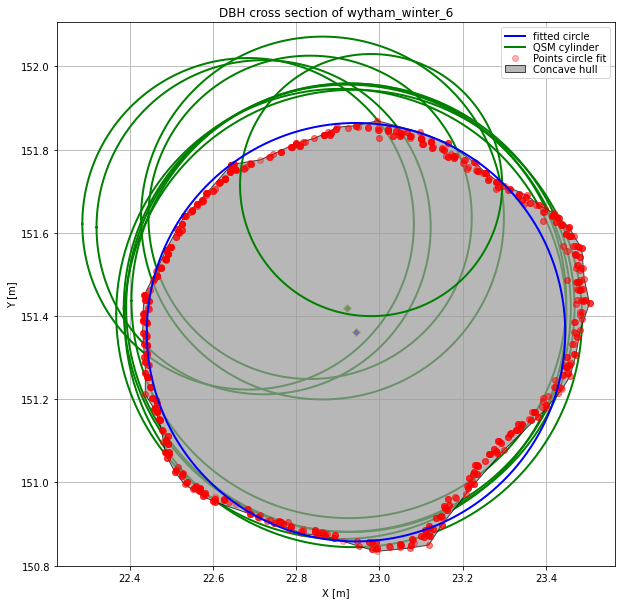

In [16]:
firsttree_pts_full = load_pts(firsttree,False,False)

xc, yc, R, residu, DBH_CH_area, DBH_CH_length,poly=calc_dbh(firsttreeID,firsttree_pts_full)

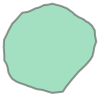

In [19]:
poly